In [183]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [230]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag", "RV"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))


def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)
    xi_eta = A_CD @ X_xy.T

    return xi_eta

def cal_plate_model_mag(X_x, X_y, mag, Y_xi, Y_eta, cof, cof_mag):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    # X_xy.append(mag * X_x)
    # X_xy.append(mag * X_y)
    # X_xy.append(mag * X_x ** 2)
    # X_xy.append(mag * X_x * X_y)
    # X_xy.append(mag * X_y ** 2)

    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model_mag(X_x, X_y, mag, A_CD, cof, cof_mag):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    # X_xy.append(mag * X_x)
    # X_xy.append(mag * X_y)
    # X_xy.append(mag * X_x ** 2)
    # X_xy.append(mag * X_x * X_y)
    # X_xy.append(mag * X_y ** 2)
    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)
    xi_eta = A_CD @ X_xy.T

    return xi_eta

# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

def sigma_filter(data, data_rel, sigma_scale):

    mean_data = np.mean(data)
    std_data = np.std(data)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter = (mean_data - sigma_scale * std_data < data) & (mean_data + sigma_scale * std_data > data)

    data_filter = data[filter]
    data_rel_filter = data_rel[filter]

    return data_filter, data_rel_filter

def sigma_filter_2(data1, data2, data_rel, sigma_scale):

    mean_data1 = np.mean(data1)
    std_data1 = np.std(data1)

    mean_data2 = np.mean(data2)
    std_data2 = np.std(data2)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter1 = (data1 > mean_data1 - sigma_scale * std_data1) & (data1 < mean_data1 + sigma_scale * std_data1)
    filter2 = (data2 > mean_data2 - sigma_scale * std_data2) & (data1 < mean_data2 + sigma_scale * std_data2)

    filter = filter1 & filter2

    data1_filter = data1[filter]
    data2_filter = data2[filter]
    data_rel_filter = data_rel[filter]

    return data1_filter, data2_filter, data_rel_filter, filter

### 文件路径

In [185]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data_validate/"

band = "C1"
obs_index = "07"
unkonw_index = "01"

obs_info = {"01": "20240119020742_20240119021242", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH + "default.sex"
sext_para_path: str = CONFIG_PATH + "default.param"
sext_filter_path: str = CONFIG_PATH + "default.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")

In [186]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [187]:
print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 265.1745710308334, -54.09801556935517


### source-extractor结果筛选

In [196]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-03-07 at 21:41:07 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits
----- Measuring from: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits [1/1]
      "Unnamed" / EXT. HEADER / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   16
> Setting up background map at line:   32
> Setting up background map at line:   48
> Setting up background map at line:   64
> Setting up background map at line:   80
> Setting up background map at line:   96
> Setting up background map at line:  112
> Setting up background map at line:  128
> Setting up background map at line:  144
> Setting up background map at line:  160
> Setting up background map at line:  176
> Setting up background map at line:  192
> Setting up background 

Filename: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13840A]   
  2  LDAC_OBJECTS    1 BinTableHDU     68   8188R x 15C   [1E, 1E, 1E, 1E, 1J, 1J, 1J, 1J, 1E, 1E, 1D, 1D, 1D, 1D, 1I]   


> Line: 9232  Objects:     8188 detected /     8000 sextracted
      Objects: detected 8188     / sextracted 8188            

> Closing files
> 
> All done (in 18.1 s: 508.7 lines/s , 451.1 detections/s)


In [200]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]


In [201]:
sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [202]:
sext_out_filter

FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,FLAGS,filter,mag_C1
float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,float64,float64,int16,int64,float64
1197.3306,27.97605,-7.695535,0.025374772,1406,59,1438,88,1421.1681,73.50756,1421.0641890224263,73.64555351311556,0.0015974912024946824,0.0017329090812256065,0,1,18.122917
661.4502,20.794205,-7.051243,0.034140904,2646,37,2676,62,2660.3203,50.468716,2660.2279661811244,50.62811352733872,0.0028099065943664424,0.003088344648160966,0,1,20.075052
293.4351,13.85108,-6.1687803,0.05126269,207,24,229,43,217.62137,33.59624,217.6186149175498,33.727401986099906,0.006735287483685782,0.006284972813385689,0,1,19.990267
1318.5029,29.357792,-7.800203,0.02418088,848,74,881,104,863.3809,89.471115,863.0629692219115,89.31874736898124,0.0015495859603903257,0.0017272348233656324,0,1,17.673443
161.81496,10.286734,-5.522547,0.06903807,5502,55,5520,74,5510.5293,64.75753,5510.434260522485,64.89728308592215,0.011779579149895976,0.009561805864637942,0,1,20.173918
5600.318,60.501976,-9.370532,0.011732396,8000,127,8053,179,8026.2803,152.41623,8026.015741087991,152.54960844297764,0.0008410810036883153,0.0005335818860714485,0,1,16.616312
424.91022,16.667065,-6.570743,0.04259825,2441,79,2467,103,2452.2122,92.30214,2452.149623310451,92.45415768317446,0.004258704466773729,0.0048549040391447145,0,1,19.545483
234.05714,12.370934,-5.9233046,0.057399802,4597,72,4618,91,4606.874,81.25212,4606.839067127629,81.3861052947058,0.007569336424454062,0.008434302481347133,0,1,21.244184
345.8392,15.036897,-6.3471856,0.047218677,6708,91,6731,113,6718.636,102.13351,6718.522478049121,102.2661161383752,0.0059689405277240214,0.005907297918734263,0,1,19.541704


In [70]:
sext_out_filter[f"mag_{band}"][sext_out_filter["X_IMAGE"] == max(sext_out_filter["X_IMAGE"])]

20.414103


### 获取gaia星表

In [71]:
df = pd.read_csv(f"validate_test/result/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img_out.txt", delimiter=" ")

refcat_ra_now = np.array(df["ra_J2025(deg)"])
refcat_dec_now = np.array(df["dec_J2025(deg)"])

refcat_ra_now_filter = refcat_ra_now[df["Gmag(mag)"] < np.percentile(df["Gmag(mag)"], 10)]
refcat_dec_now_filter = refcat_dec_now[df["Gmag(mag)"] < np.percentile(df["Gmag(mag)"], 10)]

In [72]:
ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.229547,265.219353,265.086876,-54.048800,-54.094112,-54.054815,0.087098,0.083971,0.045705
1,265.219353,265.229547,265.103242,-54.094112,-54.048800,-54.132408,0.111705,0.078097,0.045705
2,265.219353,265.229547,265.129964,-54.094112,-54.048800,-54.086144,0.069351,0.053030,0.045705
3,265.219353,265.229547,265.130323,-54.094112,-54.048800,-54.112466,0.086266,0.055334,0.045705
4,265.220460,265.229547,265.219353,-54.054388,-54.048800,-54.094112,0.045705,0.039729,0.007726
...,...,...,...,...,...,...,...,...,...
392079,265.184420,265.196220,265.156256,-54.049368,-54.044034,-54.146548,0.105159,0.098572,0.008744
392080,265.139933,265.184420,265.125547,-54.064231,-54.049368,-54.132446,0.089967,0.068735,0.030047
392081,265.125547,265.156256,265.139933,-54.132446,-54.146548,-54.064231,0.082871,0.068735,0.022858
392082,265.125547,265.156256,265.184420,-54.132446,-54.146548,-54.049368,0.098572,0.089967,0.022858


### 三角匹配

In [73]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [74]:
sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.129737,265.229440,265.262997,-54.101925,-54.048012,-54.141777,0.095808,0.087679,0.079553,1.0,0.0,2.0,1.0,0.0,2.0
1,265.129737,265.093299,265.229440,-54.101925,-54.155183,-54.048012,0.133634,0.079553,0.057379,1.0,3.0,0.0,1.0,3.0,0.0
2,265.129737,265.119129,265.229440,-54.101925,-54.147760,-54.048012,0.118887,0.079553,0.046254,1.0,4.0,0.0,1.0,4.0,0.0
3,265.245537,265.229440,265.129737,-54.063922,-54.048012,-54.101925,0.079553,0.077837,0.018505,5.0,0.0,1.0,5.0,0.0,1.0
4,265.129737,265.130901,265.229440,-54.101925,-54.118786,-54.048012,0.091380,0.079553,0.016875,1.0,6.0,0.0,1.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,265.110367,265.159164,265.164202,-54.121543,-54.155132,-54.081747,0.073445,0.050795,0.044107,35.0,38.0,39.0,35.0,38.0,39.0
9876,265.159164,265.272366,265.071367,-54.155132,-54.102689,-54.041350,0.132937,0.124888,0.084559,38.0,36.0,37.0,38.0,36.0,37.0
9877,265.164202,265.272366,265.071367,-54.081747,-54.102689,-54.041350,0.132937,0.067828,0.066804,39.0,36.0,37.0,39.0,36.0,37.0
9878,265.164202,265.272366,265.159164,-54.081747,-54.102689,-54.155132,0.084559,0.073445,0.066804,39.0,36.0,38.0,39.0,36.0,38.0


In [75]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,265.129737,265.102894,265.229440,-54.101925,-54.117706,-54.048012,1.0,16.0,0.0,1.0,16.0,0.0,265.209747,265.244255,265.083313,-54.052234,-54.042841,-54.080800
1,265.229440,265.216525,265.262997,-54.048012,-54.042643,-54.141777,0.0,28.0,2.0,0.0,28.0,2.0,265.188113,265.194363,265.245315,-54.133320,-54.141847,-54.043576
2,265.128345,265.119129,265.229440,-54.142037,-54.147760,-54.048012,8.0,4.0,0.0,8.0,4.0,0.0,265.089620,265.076920,265.248147,-54.095954,-54.093514,-54.157123
3,265.245537,265.229440,265.261785,-54.063922,-54.048012,-54.101960,5.0,0.0,20.0,5.0,0.0,20.0,265.225382,265.257023,265.161229,-54.153488,-54.152780,-54.141951
4,265.218693,265.219247,265.229440,-54.083641,-54.109942,-54.048012,10.0,7.0,0.0,10.0,7.0,0.0,265.178971,265.204857,265.148442,-54.137968,-54.159436,-54.106610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,265.124086,265.092645,265.159164,-54.043101,-54.043828,-54.155132,27.0,29.0,38.0,27.0,29.0,38.0,265.225382,265.257023,265.189848,-54.153488,-54.152780,-54.041552
761,265.124086,265.081434,265.249186,-54.043101,-54.113629,-54.066981,27.0,33.0,31.0,27.0,33.0,31.0,265.148442,265.229547,265.248147,-54.106610,-54.048800,-54.157123
762,265.164202,265.124086,265.272366,-54.081747,-54.043101,-54.102689,39.0,27.0,36.0,39.0,27.0,36.0,265.184933,265.246702,265.071100,-54.114331,-54.087334,-54.109808
763,265.249186,265.280393,265.128940,-54.066981,-54.054178,-54.063660,31.0,32.0,30.0,31.0,32.0,30.0,265.209747,265.244255,265.155240,-54.052234,-54.042841,-54.115325


### 结果验证

In [206]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


In [207]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# index = 100
# plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
# plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

### 初步底片模型

In [208]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))

A_CD_PRE = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[ 43.02168493 -38.82747615  -4.76595383 -23.41372224  34.54818143
  28.38015928 -27.0449309  -11.89793904]
[ 2.45419265 -1.82426628  1.42227483 -1.44105719  1.41494274  3.05676025
 -5.59260207  0.50974733]


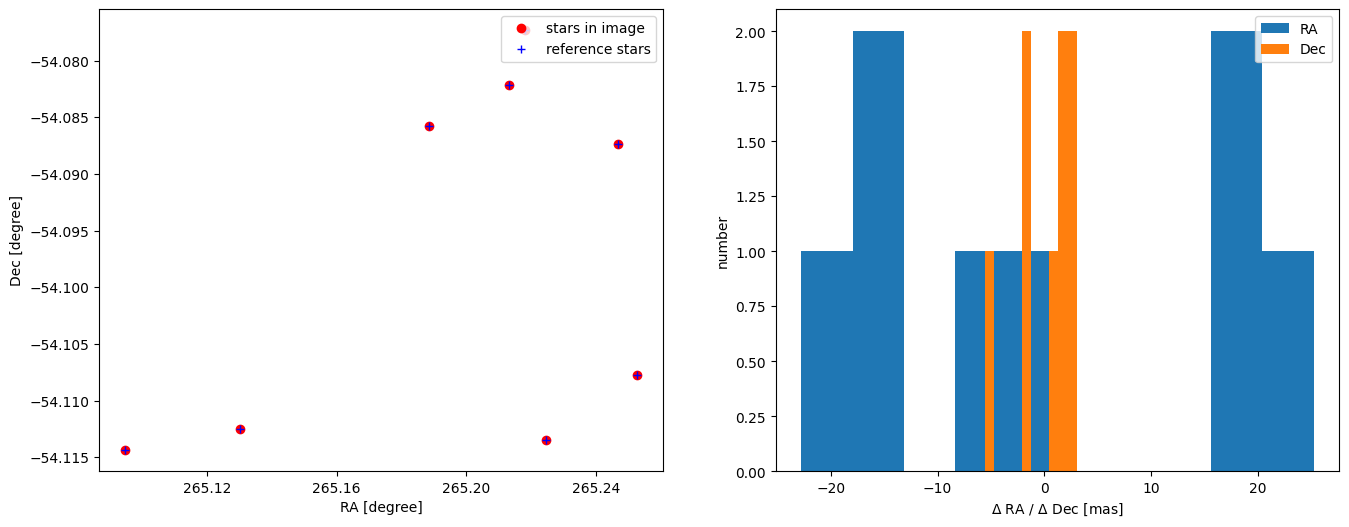

In [209]:
# fig, axes = plt.subplots(1, 3, figsize= (16, 6))

# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

# axes[2].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[2].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=1)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("number")
axes[1].legend(loc=1)

### 更新底片模型

In [210]:
# 全体星应用
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]
# sext_out_x = sext_out_filter[:]["X_IMAGE"]
# sext_out_y = sext_out_filter[:]["Y_IMAGE"]
sext_out_mag_bp = sext_out_filter[:][f"mag_{band}"][sext_flags == 0]
sext_out_mag_auto = sext_out_filter[:]["MAG_AUTO"][sext_flags == 0]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now})
side_threshold = 0.0001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all - temp_lib) < side_threshold, axis=1) ==2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), np.array(refcat_lib_all[index].loc[:, :"DE_ICRS"])[0])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all / (np.pi / 180)
Y_eta = match_res_eta_gaia_all / (np.pi / 180)

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_bp_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_auto_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    match_res_mag_bp_all[index] = sext_out_mag_bp[int(i)]
    match_res_mag_auto_all[index] = sext_out_mag_auto[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag_bp = match_res_mag_bp_all
match_mag_auto = match_res_mag_auto_all

print("the matched stars", len(match_x))

cof = min(int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2)), 4)
cof = 4
cof_mag = 4
A_CD = cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag_bp, Y_xi, Y_eta, cof, cof_mag)
# A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
# A_CD = cal_plate_model_(match_x - x_ref, match_y - y_ref, match_mag_bp, Y_xi, Y_eta)
print(A_CD)

# 再应用底片模型
match_xieta = use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag_bp, A_CD, cof, cof_mag)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model_(match_x - x_ref, match_y - y_ref, match_mag_bp, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

# plt.plot(match_x, match_y, '.')
print(np.std(dis_ra), np.std(dis_dec), cof)

the matched stars 909
[[-1.41830280e-04  1.38910485e-05 -5.32815254e-09  7.34995151e-13
   2.05926777e-11  6.11633841e-14 -7.67561229e-16 -1.33009623e-17
  -9.52220060e-16  1.91824655e-17  4.33412696e-21  1.25529528e-20
   2.99082839e-21  2.04337291e-20  1.71808764e-21  1.84327288e-05
  -8.62368516e-07  1.10030241e-08  9.16702311e-11  1.66441701e-11
  -2.03836278e-12 -1.09366585e-14 -6.83932024e-15  1.30615534e-14]
 [-1.74761464e-04  6.52938084e-09 -1.39005595e-05 -1.35431102e-11
  -5.75825674e-13 -3.73363285e-11  2.96398439e-18  9.36642597e-16
  -6.91786444e-18  1.13944902e-15 -7.17877512e-21 -4.71316877e-21
  -9.24559437e-21  2.11961777e-20  8.25502410e-21  4.86018813e-05
  -4.56716902e-06  1.86262835e-07 -2.79306072e-09  2.07290774e-11
   3.56935722e-11  1.06095099e-14  4.05217000e-15 -4.95831320e-15]]
16.517816739097206 12.879928285191252 4


In [211]:
match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "MAG_BP": match_mag_bp, "MAG_AUTO": match_mag_auto})

with open(f'match_res/match_{band}_{unkonw_index}_res.pkl', 'wb') as f:
    pickle.dump(match_res_pickle, f)

### 残差图

In [231]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

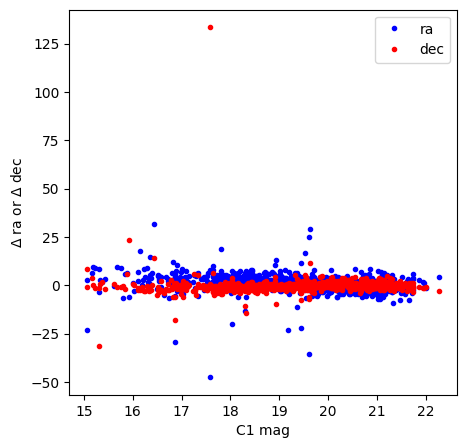

In [232]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))


for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_bp[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        # dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        # dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

        # index_ra = (match_mag_ra_box < -5) & (match_mag_ra_box > -14)
        # index_dec = (match_mag_dec_box < -5) & (match_mag_dec_box > -14)

        dis_ra_box, dis_dec_box, match_mag_radec_box, filter = sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_ra_dec = (match_mag_radec_box < 29) & (match_mag_radec_box > 15)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_radec_box[index_ra_dec], dis_ra_box[index_ra_dec], '.', c='blue', label="ra")
        axe.plot(match_mag_radec_box[index_ra_dec], dis_dec_box[index_ra_dec], '.', c='red', label="dec")
        axe.set_xlabel(f"{band} mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axe.legend()
            


In [ ]:
# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):

#         # 各个区域画图
#         dict_mag_dis.update({str(i)+str(j): []})
#         index = (bins_x_id == i) & (bins_y_id == j)
#         match_mag_box = match_mag_auto[index]
#         match_x_box = match_x[index]
#         match_y_box = match_y[index]
#         dis_ra_box = dis_ra[index]
#         dis_dec_box = dis_dec[index]
#         dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
#         dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

#         index_ra = match_mag_ra_box < -5
#         index_dec = match_mag_dec_box < -5

#         axe = axes if bins_num == 1 else axes[i][j]
#         axe.plot(match_mag_ra_box[index_ra], dis_ra_box[index_ra], '.', c='blue', label="ra")
#         axe.plot(match_mag_dec_box[index_dec], dis_dec_box[index_dec], '.', c='red', label="dec")
#         axe.set_xlabel("mag")
#         axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
#         axe.legend()

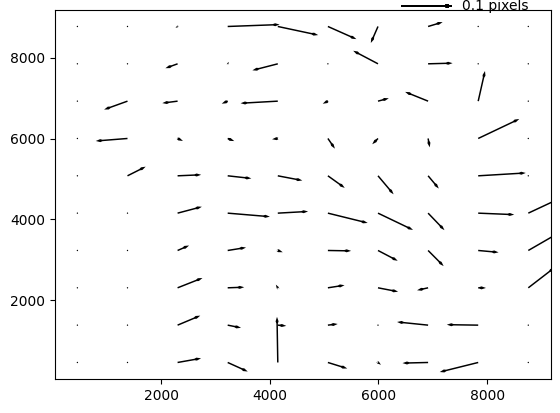

In [233]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_ra_dec], match_y[filter][index_ra_dec], dis_ra[filter][index_ra_dec], dis_dec[filter][index_ra_dec]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')

In [ ]:
# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         axes[i][j].plot(dict_mag_dis[str(i)+str(j)][0], dict_mag_dis[str(i)+str(j)][1], '.')
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\sigma$ dec")


In [ ]:
# dict_mag_dis["21"]

# x = dict_mag_dis["21"][0]
# y = dict_mag_dis["21"][1]

# X = np.array([np.ones_like(x), x]).T
# Y = y
# A = np.linalg.inv(X.T @ X) @ X.T @ Y

# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][1], '.')
# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][0] * A[1] + A[0], '.')

### test

In [ ]:
# # create bins
# bins_num = 4
# bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
# bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# # bins' centers of all box
# bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
# bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
# bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# # calculate distortion error model
# distort_sum_bins = np.zeros((bins_num, bins_num))
# distort_sum_values_x = np.zeros((bins_num, bins_num))
# distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
# [distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

# distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
# distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# # mag-distortion
# bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         index = (bins_x_id == i) & (bins_y_id == j)
#         axes[i][j].plot(match_mag[index] * match_x[index], dis_dec[index], '.')

# ax = plt.matshow(distort_sum_bins)
# plt.colorbar(ax.colorbar, fraction=0.025)

In [ ]:
# fig, axes = plt.subplots(1, 2)
# axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

# axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()